# Pilosophy School Classifier 🎓📚
---

In [1]:
import spacy
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras import layers
from keras.layers import TextVectorization, GRU, SimpleRNN, Embedding, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Input, Bidirectional, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
tf.random.set_seed(72)

## [1] Data Loading
---

In [3]:
colab = '/content/drive/MyDrive/Colab Notebooks'
file_path = colab + '/Kaggle/philosophy/philosophy_data.csv'

data = pd.read_csv(file_path)

### [1-1] data information

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360808 entries, 0 to 360807
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   title                      360808 non-null  object
 1   author                     360808 non-null  object
 2   school                     360808 non-null  object
 3   sentence_spacy             360808 non-null  object
 4   sentence_str               360808 non-null  object
 5   original_publication_date  360808 non-null  int64 
 6   corpus_edition_date        360808 non-null  int64 
 7   sentence_length            360808 non-null  int64 
 8   sentence_lowered           360808 non-null  object
 9   tokenized_txt              360808 non-null  object
 10  lemmatized_str             360808 non-null  object
dtypes: int64(3), object(8)
memory usage: 30.3+ MB


In [5]:
data.head(5)

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


### [1-2] data labels

In [6]:
print(data['school'].unique())
print(data['school'].value_counts())

['plato' 'aristotle' 'empiricism' 'rationalism' 'analytic' 'continental'
 'phenomenology' 'german_idealism' 'communism' 'capitalism' 'stoicism'
 'nietzsche' 'feminism']
analytic           55425
aristotle          48779
german_idealism    42136
plato              38366
continental        33779
phenomenology      28573
rationalism        22949
empiricism         19931
feminism           18635
capitalism         18194
communism          17958
nietzsche          13548
stoicism            2535
Name: school, dtype: int64


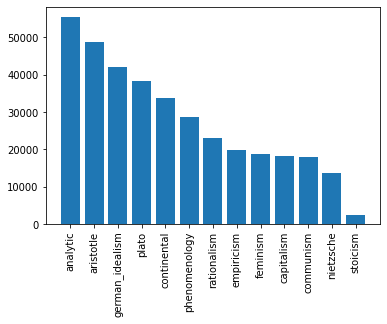

In [7]:
# show data
x = data['school'].value_counts().index
y = data['school'].value_counts()

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

### [1-2] drop stoicism

In [8]:
data_idx = data[data['school'] == 'stoicism'].index

data_drop = data.drop(data_idx).reset_index(drop=True)

In [9]:
data_pre = data_drop.loc[:, ['school', 'sentence_str']]
data_pre = data_pre.rename(columns={'school': 'label', 'sentence_str': 'sentence'})

In [10]:
data_pre.head(5)

,label,sentence
0,plato,"What's new, Socrates, to make you leave your ..."
1,plato,Surely you are not prosecuting anyone before t...
2,plato,The Athenians do not call this a prosecution b...
3,plato,What is this you say?
4,plato,"Someone must have indicted you, for you are no..."


## [2] Data Preprocessing
---


### [2-1] split data and label

In [11]:
X = np.array(data_pre['sentence'])

y_raw = data_pre['label']

# label encoding
le = LabelEncoder()
le.fit(y_raw)
y = le.transform(y_raw)
print(np.unique(y))

# save label class
y_class = le.classes_
print(y_class)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
['analytic' 'aristotle' 'capitalism' 'communism' 'continental'
 'empiricism' 'feminism' 'german_idealism' 'nietzsche' 'phenomenology'
 'plato' 'rationalism']


### @@ cleaning
- 성능 저하가 심함

In [12]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

stopwords=nltk.corpus.stopwords.words('english')

In [13]:
def cleaning_data(datas, remove_data):
    for idx in range(len(datas)):
        words = word_tokenize(datas[idx])
        _clear=[]
        for word in words:
            if word not in remove_data:
                _clear.append(word)

        datas[idx]=' '.join(_clear)

    return datas

In [14]:
# X_train_cleaned = cleaning_data(X_train, stopwords)

### [2-2] dataset

In [15]:
# split train test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=72
)

In [16]:
# data to tf.dataset

batch_size = 32

plot_ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(1)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

### [2-3] make text preprocessing layer and voca

In [17]:
# make vectorize layer and adapt train text
max_feature = 1000
max_len = 1000

vectorize_layer = TextVectorization(
    max_tokens=max_feature,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=max_len,
    name = "vectorize_layer"
)

train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
    # text to vector
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [19]:
plot_ds_vec = plot_ds.map(vectorize_text)

result = []

for i in plot_ds_vec.as_numpy_iterator():
    cut = np.count_nonzero(i[0])
    result.append(cut)

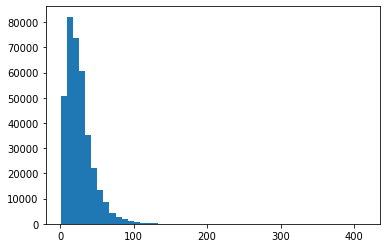

In [20]:
# output_sequence_length => 50
plt.hist(result, bins=50)
plt.show()

In [21]:
# make vectorize layer and adapt train text
max_feature = 1000
max_len = 50

vectorize_layer = TextVectorization(
    max_tokens=max_feature,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=max_len,
    name = "vectorize_layer"
)

train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [22]:
# map vactorize_text into dataset
train_ds_vec = train_ds.map(vectorize_text)
val_ds_vec = val_ds.map(vectorize_text)

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_vec = configure_dataset(train_ds_vec)
val_ds_vec = configure_dataset(val_ds_vec)

## [3] Make Model
---

In [27]:
embed_dim = 15
hidden_node = 128
second = int(hidden_node/2)
drop_out=0.3

model = Sequential(name="school_classifier")
model.add(Embedding(max_len, embed_dim, mask_zero=True, name='embed'))
model.add(GRU(hidden_node, name='gru_layer'))
model.add(Dropout(drop_out, name='drop'))
model.add(Dense(12, activation='softmax', name='out'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "school_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed (Embedding)           (None, None, 15)          750       
                                                                 
 gru_layer (GRU)             (None, 128)               55680     
                                                                 
 drop (Dropout)              (None, 128)               0         
                                                                 
 out (Dense)                 (None, 12)                1548      
                                                                 
Total params: 57,978
Trainable params: 57,978
Non-trainable params: 0
_________________________________________________________________


## [4] Train Model
---

### [4-1] call backs

In [28]:
stop_cb = EarlyStopping(
    patience=4,
    restore_best_weights=True
)

### [4-2] fit

In [29]:
his = model.fit(
    train_ds_vec,
    epochs=100,
    validation_data=val_ds_vec,
    callbacks=[stop_cb]
)

Epoch 1/100
8397/8397 [==============================] - 74s 8ms/step - loss: 2.1335 - accuracy: 0.2705 - val_loss: 2.0535 - val_accuracy: 0.3003
Epoch 2/100
8397/8397 [==============================] - 67s 8ms/step - loss: 2.0332 - accuracy: 0.3096 - val_loss: 2.0006 - val_accuracy: 0.3201
Epoch 3/100
8397/8397 [==============================] - 68s 8ms/step - loss: 1.9866 - accuracy: 0.3270 - val_loss: 1.9663 - val_accuracy: 0.3331
Epoch 4/100
8397/8397 [==============================] - 67s 8ms/step - loss: 1.9531 - accuracy: 0.3402 - val_loss: 1.9409 - val_accuracy: 0.3431
Epoch 5/100
8397/8397 [==============================] - 67s 8ms/step - loss: 1.9250 - accuracy: 0.3510 - val_loss: 1.9224 - val_accuracy: 0.3500
Epoch 6/100
8397/8397 [==============================] - 67s 8ms/step - loss: 1.9019 - accuracy: 0.3604 - val_loss: 1.9075 - val_accuracy: 0.3560
Epoch 7/100
8397/8397 [==============================] - 66s 8ms/step - loss: 1.8830 - accuracy: 0.3663 - val_loss: 1.8984 -

### [4-3] plot history

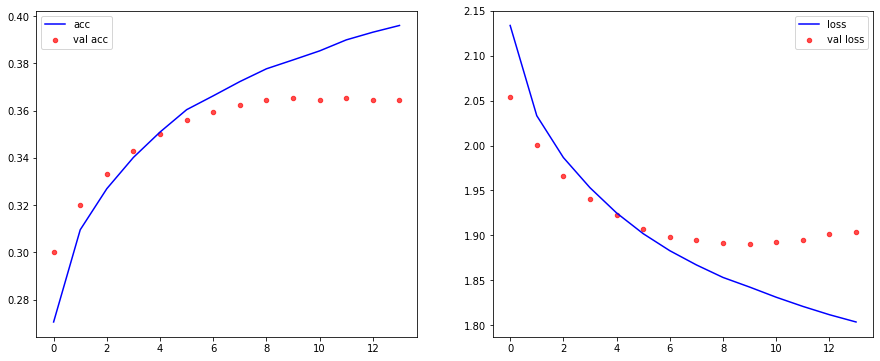

In [30]:
x = his.epoch
acc = his.history["accuracy"]
val_acc = his.history["val_accuracy"]
loss = his.history["loss"]
val_loss = his.history["val_loss"]


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(x, acc, label="acc", color="blue")
plt.scatter(x, val_acc, label="val acc", color="red", alpha=0.7, s=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, loss, label="loss", color="blue")
plt.scatter(x, val_loss, label="val loss", color="red", alpha=0.7, s=20)
plt.legend()

plt.show()

## [5] Export Model
---

In [31]:
export_model = Sequential(name="school_classifier_export")
export_model.add(vectorize_layer)
export_model.add(model)

export_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

export_model.summary()

Model: "school_classifier_export"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vectorize_layer (TextVector  (None, 50)               0         
 ization)                                                        
                                                                 
 school_classifier (Sequenti  (None, 12)               57978     
 al)                                                             
                                                                 
Total params: 57,978
Trainable params: 57,978
Non-trainable params: 0
_________________________________________________________________


In [32]:
# model init
loss, accuracy = export_model.evaluate(val_ds)

2800/2800 [==============================] - 14s 4ms/step - loss: 1.8903 - accuracy: 0.3653


In [33]:
# model save
model_path = colab + '/Models/philsophy2'

export_model.save(model_path, save_format="tf")

## [6] Predict
---

In [46]:
def predict_school(input):
    scores = np.round(export_model.predict(input), 2)
    scores_list = list(scores[0])
    y_class = ['analytic', 'aristotle', 'capitalism', 'communism', 'continental',
               'empiricism', 'feminism', 'german_idealism', 'nietzsche', 'phenomenology',
               'plato', 'rationalism']

    scores_class = list(zip(y_class, scores_list))

    pred_idx = scores.argmax()
    result = y_class[pred_idx]

    print(f"예측 점수 : {scores_class}")
    print(f"당신의 학파는 {result} 입니다...")

In [47]:
input = ["Wise men speak because they have something to say; fools because they have to say something."]
predict_school(input)

예측 점수 : [('analytic', 0.1), ('aristotle', 0.15), ('capitalism', 0.02), ('communism', 0.02), ('continental', 0.01), ('empiricism', 0.04), ('feminism', 0.08), ('german_idealism', 0.04), ('nietzsche', 0.08), ('phenomenology', 0.02), ('plato', 0.35), ('rationalism', 0.09)]
당신의 학파는 plato 입니다...


In [48]:
MS = ["no pain no gain, just the way you are"]
predict_school(MS)

예측 점수 : [('analytic', 0.33), ('aristotle', 0.11), ('capitalism', 0.02), ('communism', 0.03), ('continental', 0.05), ('empiricism', 0.05), ('feminism', 0.03), ('german_idealism', 0.06), ('nietzsche', 0.03), ('phenomenology', 0.03), ('plato', 0.25), ('rationalism', 0.03)]
당신의 학파는 analytic 입니다...


In [49]:
HJ = ["let's go"]
predict_school(HJ)

예측 점수 : [('analytic', 0.19), ('aristotle', 0.04), ('capitalism', 0.02), ('communism', 0.07), ('continental', 0.08), ('empiricism', 0.03), ('feminism', 0.04), ('german_idealism', 0.16), ('nietzsche', 0.04), ('phenomenology', 0.09), ('plato', 0.18), ('rationalism', 0.07)]
당신의 학파는 analytic 입니다...


In [50]:
GY = ["let's be nice"]
predict_school(GY)

예측 점수 : [('analytic', 0.2), ('aristotle', 0.09), ('capitalism', 0.02), ('communism', 0.05), ('continental', 0.09), ('empiricism', 0.03), ('feminism', 0.06), ('german_idealism', 0.08), ('nietzsche', 0.1), ('phenomenology', 0.06), ('plato', 0.18), ('rationalism', 0.05)]
당신의 학파는 analytic 입니다...


In [51]:
HS = ["leehyejin is retiring"]
predict_school(HS)

예측 점수 : [('analytic', 0.24), ('aristotle', 0.1), ('capitalism', 0.01), ('communism', 0.04), ('continental', 0.12), ('empiricism', 0.02), ('feminism', 0.08), ('german_idealism', 0.11), ('nietzsche', 0.06), ('phenomenology', 0.1), ('plato', 0.07), ('rationalism', 0.05)]
당신의 학파는 analytic 입니다...


In [52]:
JY = ["life is all alone"]
predict_school(JY)

예측 점수 : [('analytic', 0.18), ('aristotle', 0.12), ('capitalism', 0.0), ('communism', 0.02), ('continental', 0.07), ('empiricism', 0.05), ('feminism', 0.04), ('german_idealism', 0.09), ('nietzsche', 0.11), ('phenomenology', 0.15), ('plato', 0.12), ('rationalism', 0.05)]
당신의 학파는 analytic 입니다...


In [53]:
HR = ["living is hell"]
predict_school(HR)

예측 점수 : [('analytic', 0.21), ('aristotle', 0.14), ('capitalism', 0.01), ('communism', 0.03), ('continental', 0.11), ('empiricism', 0.03), ('feminism', 0.1), ('german_idealism', 0.09), ('nietzsche', 0.05), ('phenomenology', 0.1), ('plato', 0.07), ('rationalism', 0.05)]
당신의 학파는 analytic 입니다...


In [54]:
JR = ["he who wants to be king, bear the weight of the crown"]
predict_school(JR)

예측 점수 : [('analytic', 0.12), ('aristotle', 0.05), ('capitalism', 0.09), ('communism', 0.07), ('continental', 0.17), ('empiricism', 0.02), ('feminism', 0.09), ('german_idealism', 0.04), ('nietzsche', 0.11), ('phenomenology', 0.04), ('plato', 0.15), ('rationalism', 0.07)]
당신의 학파는 continental 입니다...


In [55]:
NG = ["Time and space are not absolute but relative to speed"]
predict_school(NG)

예측 점수 : [('analytic', 0.16), ('aristotle', 0.28), ('capitalism', 0.02), ('communism', 0.02), ('continental', 0.09), ('empiricism', 0.07), ('feminism', 0.05), ('german_idealism', 0.07), ('nietzsche', 0.02), ('phenomenology', 0.06), ('plato', 0.12), ('rationalism', 0.05)]
당신의 학파는 aristotle 입니다...


In [56]:
JH = ["Let's not waste new tears on the past anymore."]
predict_school(JH)

예측 점수 : [('analytic', 0.18), ('aristotle', 0.04), ('capitalism', 0.02), ('communism', 0.08), ('continental', 0.15), ('empiricism', 0.02), ('feminism', 0.12), ('german_idealism', 0.07), ('nietzsche', 0.12), ('phenomenology', 0.1), ('plato', 0.06), ('rationalism', 0.05)]
당신의 학파는 analytic 입니다...


In [57]:
teacher = ["Let's live sincerely"]
predict_school(teacher)

예측 점수 : [('analytic', 0.18), ('aristotle', 0.05), ('capitalism', 0.02), ('communism', 0.08), ('continental', 0.09), ('empiricism', 0.03), ('feminism', 0.05), ('german_idealism', 0.13), ('nietzsche', 0.06), ('phenomenology', 0.08), ('plato', 0.16), ('rationalism', 0.07)]
당신의 학파는 analytic 입니다...


In [66]:
ttt = ["hammer"]
predict_school(ttt)

예측 점수 : [('analytic', 0.18), ('aristotle', 0.06), ('capitalism', 0.03), ('communism', 0.07), ('continental', 0.11), ('empiricism', 0.04), ('feminism', 0.04), ('german_idealism', 0.15), ('nietzsche', 0.05), ('phenomenology', 0.09), ('plato', 0.11), ('rationalism', 0.07)]
당신의 학파는 analytic 입니다...
